# TP OpenMP - October 2022

Florian Rascoussier

Bastien Barbe

Ce notebook constitue une étude comparative des méthodes de parallélisation Open MP sur CPU pour différentes applications.

## Part 5 : Chaining Matrix Multiplication

Ce programme calcule des produits de matrices carrées.

### Compilation

In [1]:
# script params
EXEC: bool = True

In [2]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
print("Compilation process:")
print("    + synchronous")
!g++ -o bin/tp_openmp_part_5_chained_matrix_mul tp_openmp_part_5_chained_matrix_mul.cpp utils.hpp -fopenmp -O3 -march=native -Wall 

print("    + omp parallel multiplication")
!g++ -o bin/tp_openmp_part_5_chained_matrix_mul_omp tp_openmp_part_5_chained_matrix_mul_omp.cpp utils.hpp -fopenmp -O3 -march=native -Wall 


Compilation process:
    + synchronous
    + omp parallel multiplication


### Performance evaluation

In [3]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'D': int,
    'N': int,
    'runtime' : float
}

matrix_params: list[dict[str, int]] = [
    {"D": 100, "N": 1},
    {"D": 1000, "N": 1},
    {"D": 100, "N": 2},
    {"D": 1000, "N": 2},
    {"D": 100, "N": 3},
    {"D": 1000, "N": 3},
    {"D": 100, "N": 4},
    {"D": 1000, "N": 4},
    {"D": 100, "N": 5},
    {"D": 1000, "N": 5},
]

color_class = {
    "sequential": "red",
    "omp": "green",
}

repeats = 10

In [4]:
import os
import subprocess

try:
    os.remove(csv_result_file)
except OSError:
    pass

# create csv file
f = open(csv_result_file, "w")
f.write(",".join(csv_headers.keys()) + "\n")
f.close()

# execute the programs
def run_program(program_filepath: str, index: int):
    args = (program_filepath, 
        "-D", str(matrix_params[i]["D"]), 
        "-N", str(matrix_params[i]["N"])
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
for _ in range(repeats):
    for i in range(0,len(matrix_params)):
        run_program("bin/tp_openmp_part_5_chained_matrix_mul", i)
        run_program("bin/tp_openmp_part_5_chained_matrix_mul_omp", i)

### Performance analysis
#### Weak scaling

,version,D,N,runtime
0,sequential,100,2,0.000594
1,omp,100,2,0.011318
2,sequential,1000,2,0.722061
3,omp,1000,2,0.203175
4,sequential,100,4,0.001783
5,omp,100,4,0.002929
6,sequential,1000,4,2.089589
7,omp,1000,4,0.570319
8,sequential,100,8,0.004251
9,omp,100,8,0.009984


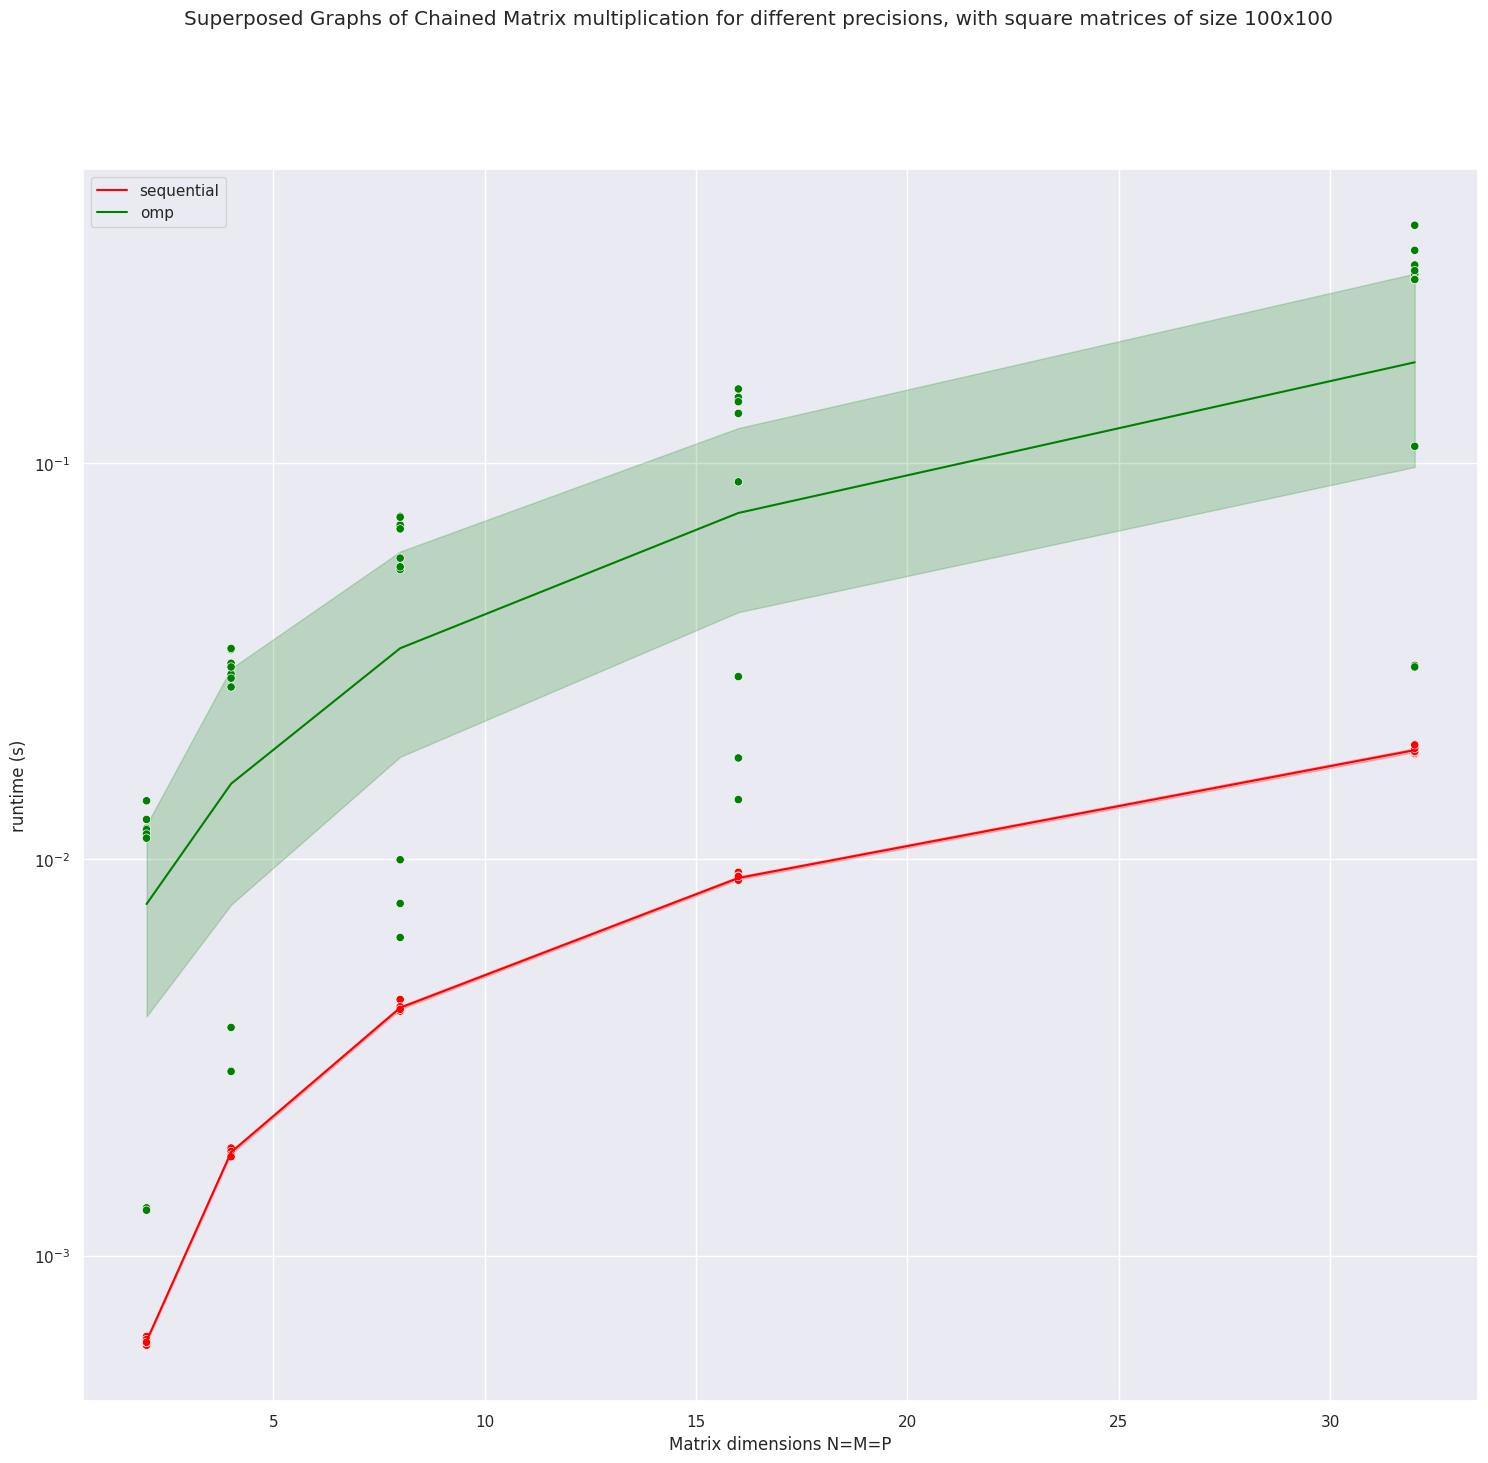

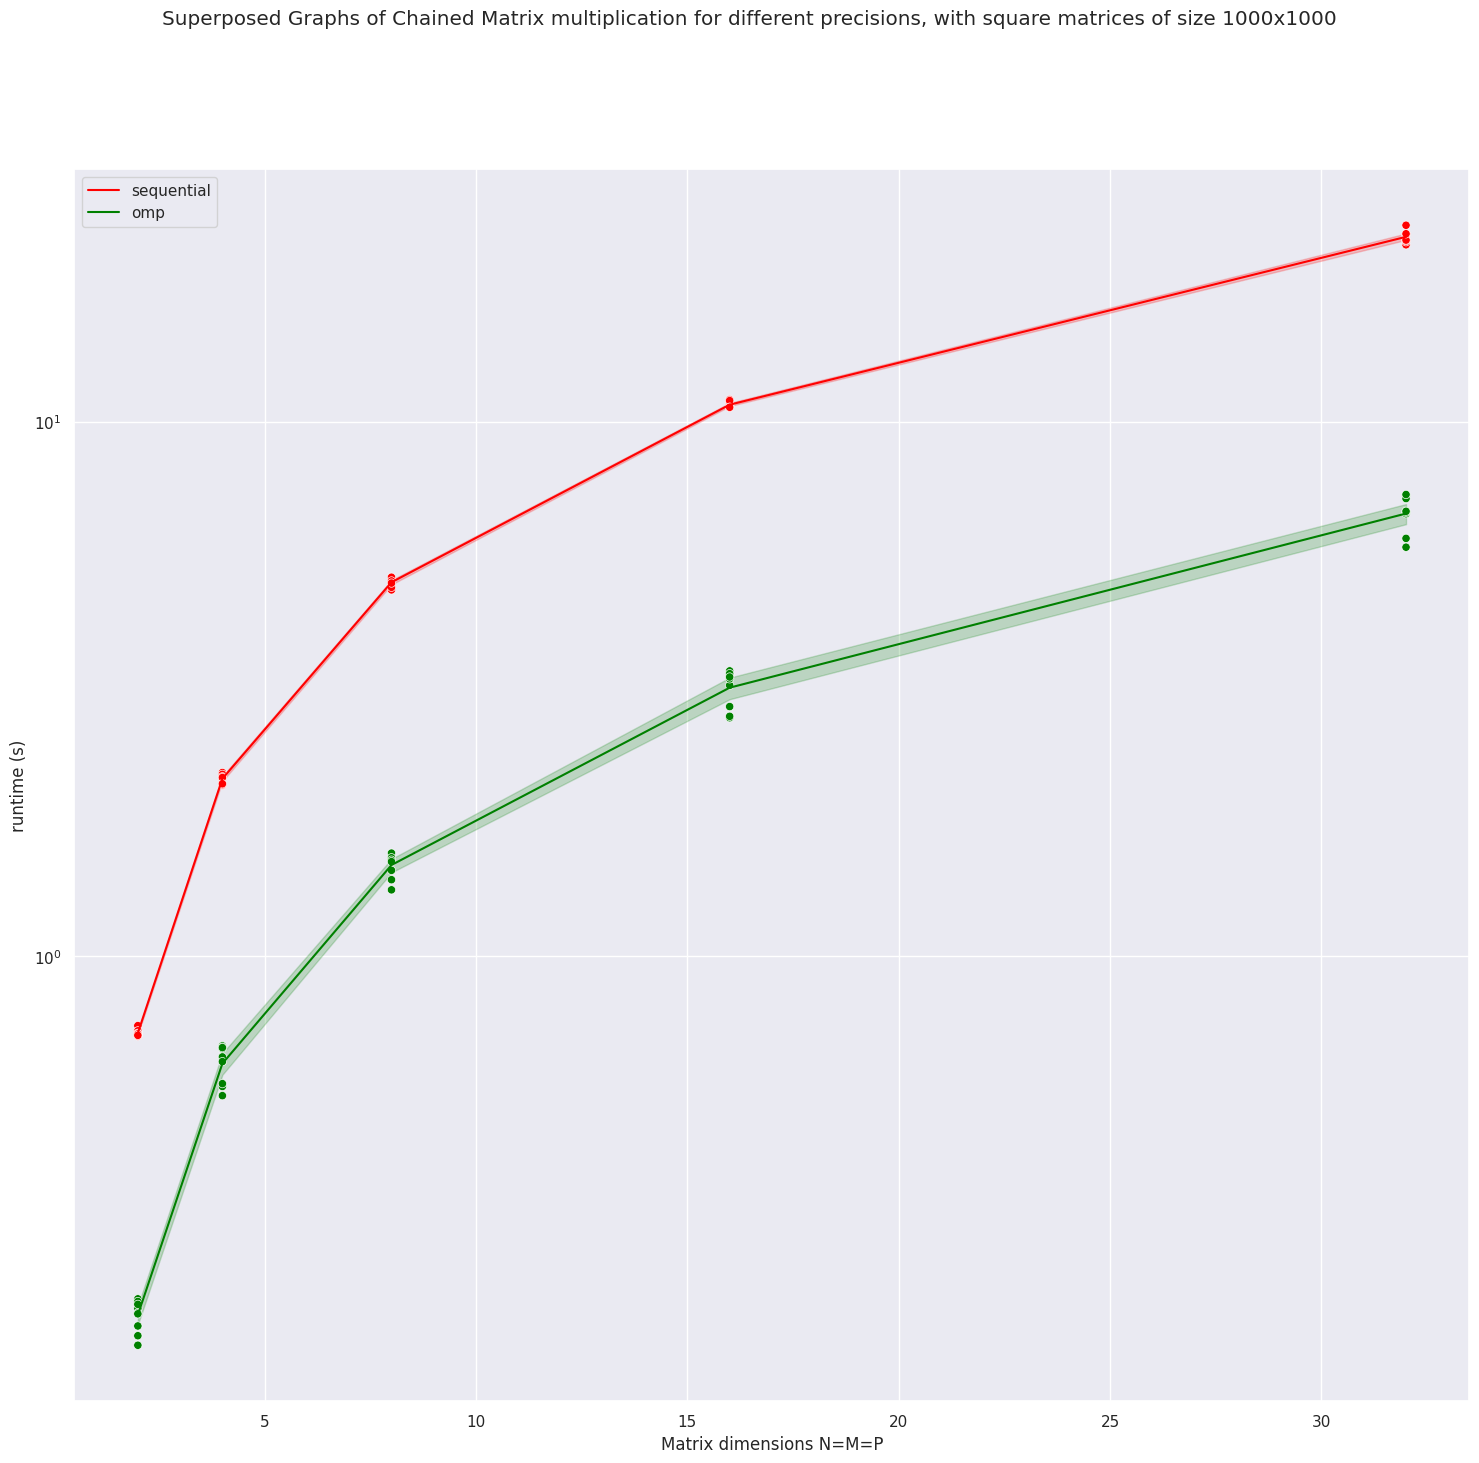

In [6]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]



# display the graph
def display_graph(D: int, df):
    fig, ax = plt.subplots(figsize=(18,16))
    fig.suptitle(f"Superposed Graphs of Chained Matrix multiplication for different precisions, with square matrices of size {D}x{D}")

    for i in range(0, len(color_class.keys())):
        # print version graph data
        graph_version = list(color_class.keys())[i]
        df_plot_0 = df[df['version'] == graph_version]

        g0 = sns.lineplot(
            ax=ax,
            data=df_plot_0, 
            x="N",
            y="runtime", 
            hue="version",
            palette=color_class,
            style="version",
        )
        g0.set(yscale="log")
        g0.set(xlabel="Matrix dimensions N=M=P", ylabel="runtime (s)")
        g00 = sns.scatterplot(
            ax=ax,
            data=df_plot_0, 
            x="N",
            y="runtime", 
            hue="version",
            palette=color_class,
            legend=False,
        )
        g00.set(yscale="log")

    plt.legend()
    plt.show()



# display graphs for D = 100
df_100 = df[df.D == 100]
df_100 = df_100.sort_values(by=['N'])
df_100 = df_100.reset_index(drop=True)
df_100 = df_100.drop(columns=['D'])
display_graph(100, df_100)

# display graphs for D = 1000
df_1000 = df[df.D == 1000]
df_1000 = df_1000.sort_values(by=['N'])
df_1000 = df_1000.reset_index(drop=True)
df_1000 = df_1000.drop(columns=['D'])
display_graph(1000, df_1000)


### Discussion

Nous avons choisi de faire les calculs pour deux tailles de matrices (dimensions D) différentes afin de comparer l'impact de celle-ci sur l'évolution des performances.

On observe que pour des valeurs de dimensions faibles (ici `D=100`), le code séquentiel est meilleur que la version Open MP. C'est l'inverse avec une grande valeur de D (ici `D=1000`). Dans ce cas, la parallélisation est donc utile.

Il faudrait tester plus de valeurs afin de découvrir le point à partir duquel le code parallèle devient plus intéressant.